In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import yfinance as yf

from model.PDV import *
from model.HMM import *
from model.data import *

# Data

In [2]:
window = 1000
log_return = True
predict_t_plus_1 = False

In [3]:
start_date = pd.to_datetime('1995-01-01')
end_date = pd.to_datetime('2023-08-31')
spx_data = pd.read_csv('spx_data_nn.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('vix_data_nn.csv', index_col=0, parse_dates=[0])
spx_data.index = pd.to_datetime(pd.to_datetime(spx_data.index, utc=True).date)
vix_data.index = pd.to_datetime(pd.to_datetime(vix_data.index, utc=True).date)
data = create_df_from_yf(spx_data, start_date, end_date, vix_data, predict_t_plus_1=predict_t_plus_1, log_return=log_return)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2023-08-24,-0.013549,1.835850e-04,0.1720
2023-08-25,0.006696,4.482973e-05,0.1568
2023-08-28,0.006245,3.900101e-05,0.1508
2023-08-29,0.014404,2.074772e-04,0.1445


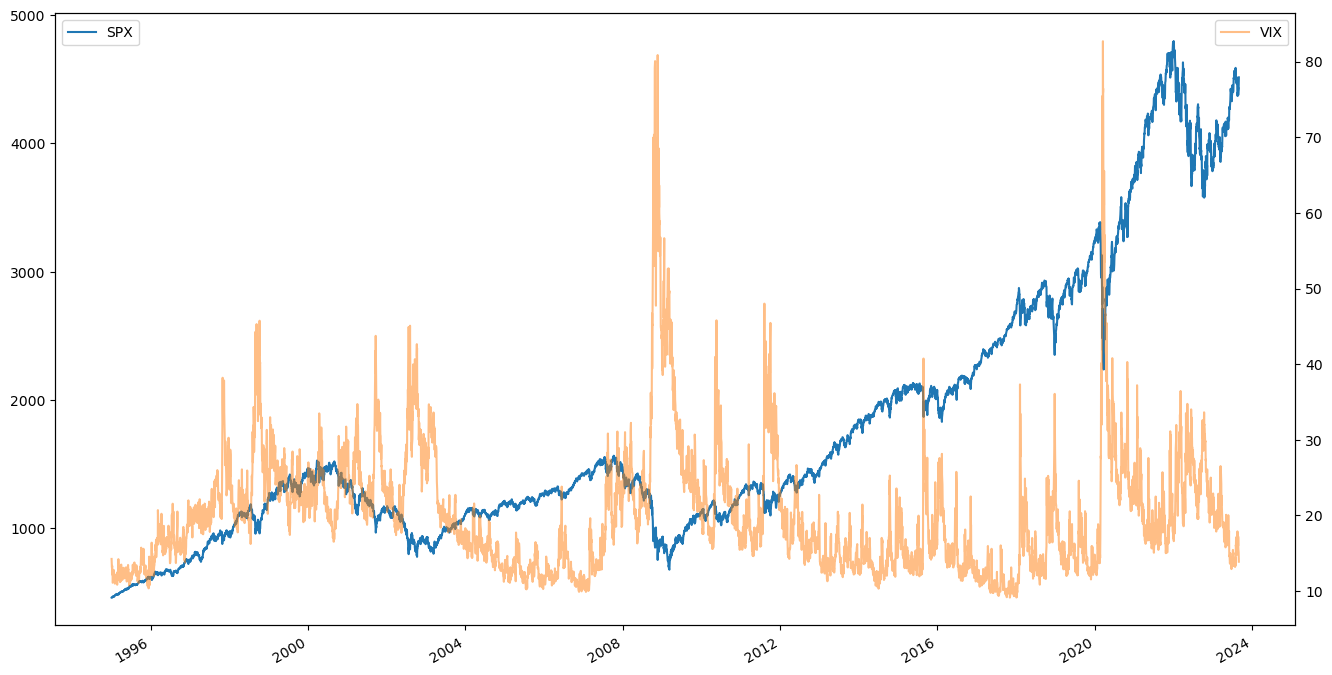

In [54]:
fig, ax = plt.subplots(figsize=(16,9))
spx_data[['Close']].plot(ax=ax, label='SPX')
ax2 = vix_data[['Close']].plot(ax=ax, label='VIX', secondary_y=True, alpha=0.5)
ax.legend(labels=['SPX'], loc='upper left')
ax2.legend(labels=['VIX'], loc='upper right')

# HMM for SPX

### Irregular time periods

In [35]:
for n in range(2, 2):
    n_regimes = n
    spx_models = []
    print(f'Number of regimes: {n_regimes}')

    for i in range(1, 6):
        print(f'Run {i}')
        spx_model = SPXHMM(n_regimes, verbose=False)
        print(f'Initial parameters μ: {spx_model.μ}, σ: {spx_model.σ}, π: {np.exp(spx_model.π)}, A: \n{np.exp(spx_model.A)}')
        spx_model.EM_optimise(spx_data, tol=1e-7)
        spx_models.append(spx_model)
        spx_model.print_params()

        # save params to dataframe and csv
        spx_model.save_params_to_csv('params.csv', i)
        print('----------------------------------')

In [36]:
df = pd.read_csv('params_v1.csv', index_col=0, converters={'μ': from_np_array, 'σ': from_np_array,
                                                        'π': from_np_array, 'A': from_np_array,
                                                        'π_alpha': from_np_array, 'A_alpha': from_np_array})
df

,n_regimes,model,μ,σ,π,A,log_likelihood
0,2,1,"[0.26033976, 0.01488166]","[0.12631492, 0.26073531]","[0.54751681, 0.45248319]","[[0.00702196, 0.99297804], [0.90095488, 0.0990...",-72881.316049
0,2,2,"[0.34174416, -0.12416645]","[0.08952189, 0.2930143]","[0.89346575, 0.10653425]","[[0.74519385, 0.25480615], [0.24459404, 0.7554...",-72167.893093
0,2,3,"[-0.37957292, 0.29332834]","[0.36678685, 0.11853461]","[0.00361386, 0.99638614]","[[0.5921114, 0.4078886], [0.11878126, 0.881218...",-72092.517076
0,2,4,"[-0.26071205, 0.29361444]","[0.34089722, 0.11344707]","[0.0684883, 0.9315117]","[[0.18376854, 0.81623146], [0.34843363, 0.6515...",-72355.024308
0,2,5,"[0.0358044, 0.29851117]","[0.2528692, 0.0843239]","[0.18521356, 0.81478644]","[[0.60007353, 0.39992647], [0.79092979, 0.2090...",-72570.743801
0,2,6,"[0.30461596, -0.29842837]","[0.11401403, 0.34320322]","[0.97146354, 0.02853646]","[[0.90030302, 0.09969698], [0.26129444, 0.7387...",-71990.861791
0,2,7,"[0.28504647, 0.03211657]","[0.0749784, 0.2598065]","[0.96132298, 0.03867702]","[[0.29564708, 0.70435292], [0.39890494, 0.6010...",-72451.546374
0,2,8,"[-0.38042628, 0.28958843]","[0.36960988, 0.11896809]","[0.79967455, 0.20032545]","[[0.23121995, 0.76878005], [0.23809688, 0.7619...",-72238.098646
0,2,9,"[-0.09859517, 0.30998338]","[0.29714604, 0.08947238]","[0.04984242, 0.95015758]","[[0.52531274, 0.47468726], [0.40728968, 0.5927...",-72230.751789
0,2,10,"[0.10543052, 0.13252655]","[0.17561721, 0.21336171]","[0.39384082, 0.60615918]","[[0.60007241, 0.39992759], [0.05609407, 0.9439...",-73406.938671


In [37]:
n_regimes = 4
model_num = 3
spx_model = SPXHMM(n_regimes, verbose=False)
spx_model.load_params_from_csv('params_v1.csv', model_num)
spx_model.predict(spx_data)

Loaded parameters from params_v1.csv


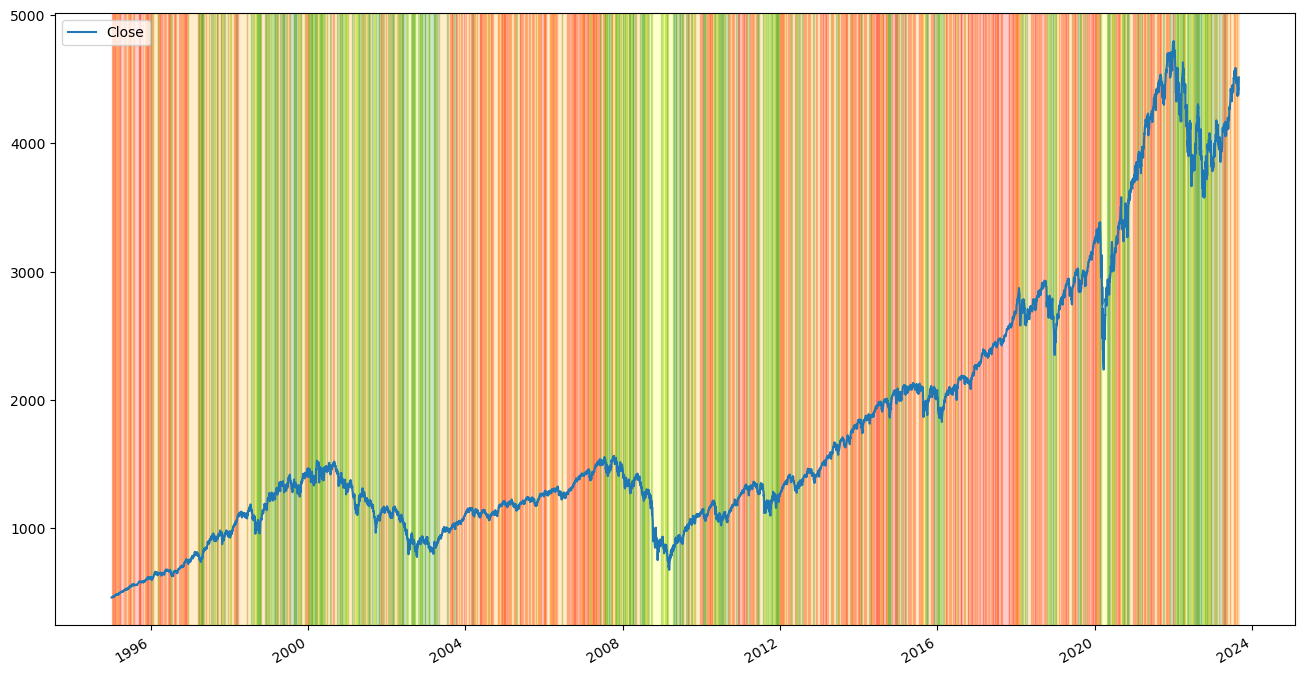

In [38]:
spx_model.plot_regimes_on_index()

### Regular time periods (using hmmlearn)

In [ ]:
# start_date = pd.to_datetime('1995-01-01')
# end_date = pd.to_datetime('2023-08-31')
# tickers = ['^GSPC', '^FTSE', '^GDAXI']
# # download data from yahoo finance
# hmm_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
# hmm_data = hmm_data['Adj Close']
# hmm_data.dropna(inplace=True)
# hmm_data = hmm_data / hmm_data.iloc[0]
# x = (np.log(hmm_data / hmm_data.shift(1)).dropna()).values
# x

,^FTSE,^GDAXI,^GSPC
Date,,,
1995-01-02,NaN,2079.189941,NaN
1995-01-03,3065.699951,2068.919922,459.109985
1995-01-04,3051.600098,2072.899902,460.709991
1995-01-05,3032.300049,2051.459961,460.339996
1995-01-06,3065.000000,2058.199951,460.679993
...,...,...,...
2023-08-24,7333.600098,15621.490234,4376.310059
2023-08-25,7338.600098,15631.820312,4405.709961
2023-08-28,NaN,15792.610352,4433.310059


Model is not converging.  Current: 23347.275810649924 is not greater than 23347.299120592856. Delta is -0.02330994293151889


Model score: 23346.7200


Model is not converging.  Current: 23059.499283655237 is not greater than 23059.50103892447. Delta is -0.0017552692333993036
Model is not converging.  Current: 23073.572787028344 is not greater than 23073.57440006298. Delta is -0.0016130346339195967


Model score: 23059.4908
Model score: 23073.5682


Model is not converging.  Current: 23063.44278819981 is not greater than 23063.447708251013. Delta is -0.004920051203953335


Model score: 23063.4309


Model is not converging.  Current: 23344.488808686474 is not greater than 23344.513517709824. Delta is -0.0247090233497147


Model score: 23344.0495
Model score: 23338.0237
Model score: 23089.6076
Model score: 23336.8568
Best model: 0
Regime 0 count: 415
Regime 1 count: 3586
Regime 2 count: 3214
mu: [-0.52324342  0.27768768 -0.01380956]
sigma: [0.48799521 0.0960592  0.19816698]
drift: [-0.64231308  0.273074   -0.03344464]
[[9.52158238e-01 7.52799856e-07 4.78410097e-02]
 [6.84366123e-07 9.78710784e-01 2.12885312e-02]
 [7.34212352e-03 2.45846421e-02 9.68073234e-01]]


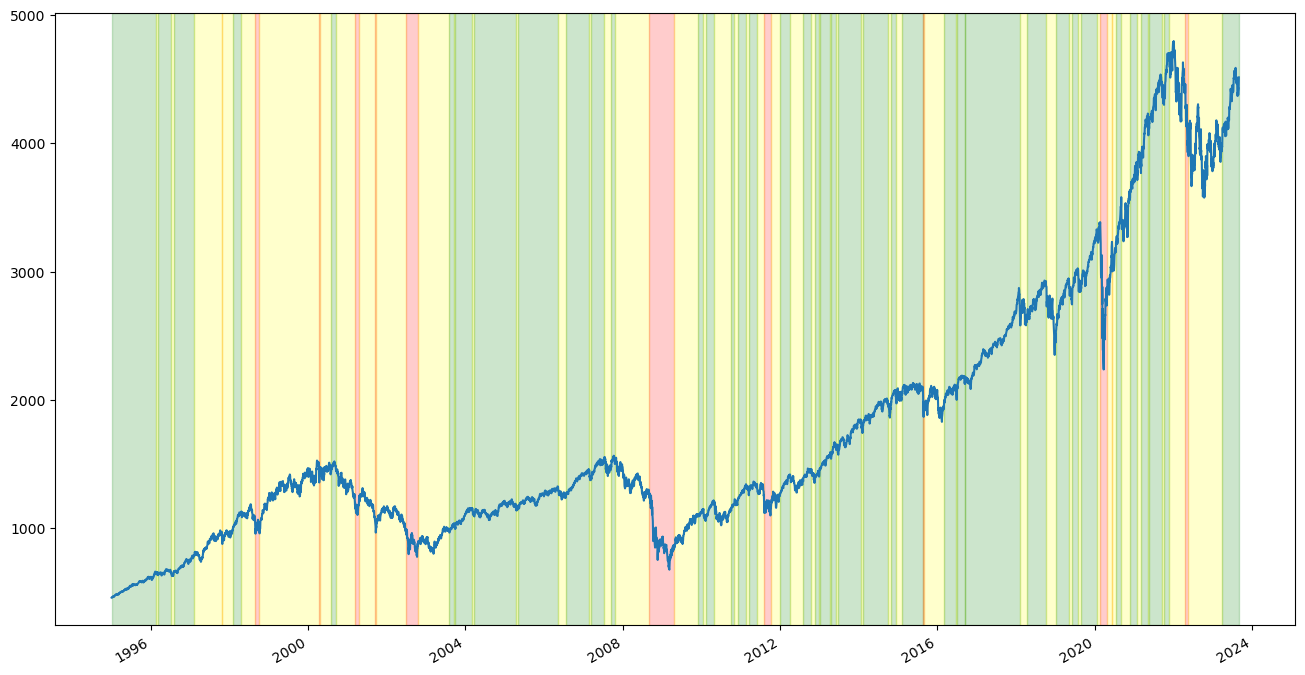

In [17]:
n_models = 8
models = []

x = np.log(spx_data['Close']).diff().dropna().values[:,np.newaxis]

n_regimes = 3
# means = np.random.normal(0.1, 0.1, size=n_regimes)
# covar = (np.eye(3)*0.2)**2
# start_prob = np.array([0.95, 0.05]) # using high prob for regime 0 helps in stablising the permutation

for _ in range(n_models):
    # model = hmm.GaussianHMM(n_components=n_regimes, covariance_type='full', means_prior=means, covars_prior=covar, startprob_prior=start_prob,
    #     n_iter=100, tol=1e-7)
    # model.init_params = ''
    model = hmm.GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=100, tol=1e-7)
    models.append(model)

high_score = -np.inf
for i in range(n_models):
    models[i].fit(x)
    preds = models[i].predict(x)
    print(f'Model score: {models[i].score(x):0.4f}')
    model_score = models[i].score(x)
    if model_score > high_score:
        best_model = i
        high_score = model_score
        best_preds = preds
print(f'Best model: {best_model}')

# plt.figure(figsize=(16, 9))
for i in range(n_regimes):
    print(f'Regime {i} count: {(best_preds == i).sum()}')

if x.shape[-1] == 1:
    spx_data['Close'].plot(figsize=(16, 9))
else:
    hmm_data.plot(figsize=(16, 9))

plot_regimes(best_preds, spx_data.index)

drift = models[best_model].means_.squeeze()
covar = (models[best_model].covars_.squeeze())
transition = models[best_model].transmat_

if x.shape[-1] == 1:
    sigma = np.sqrt(covar*252)
else:
    sigma = []
    for i in range(n_regimes):
        sigma.append(np.sqrt(covar[i].diagonal()*252))
    sigma = np.array(sigma)
mu = (drift*252) + sigma**2/2
pi = models[best_model].startprob_
print(f'mu: {mu}')
print(f'sigma: {sigma}')
print(f'drift: {mu-sigma**2/2}')
print(transition)

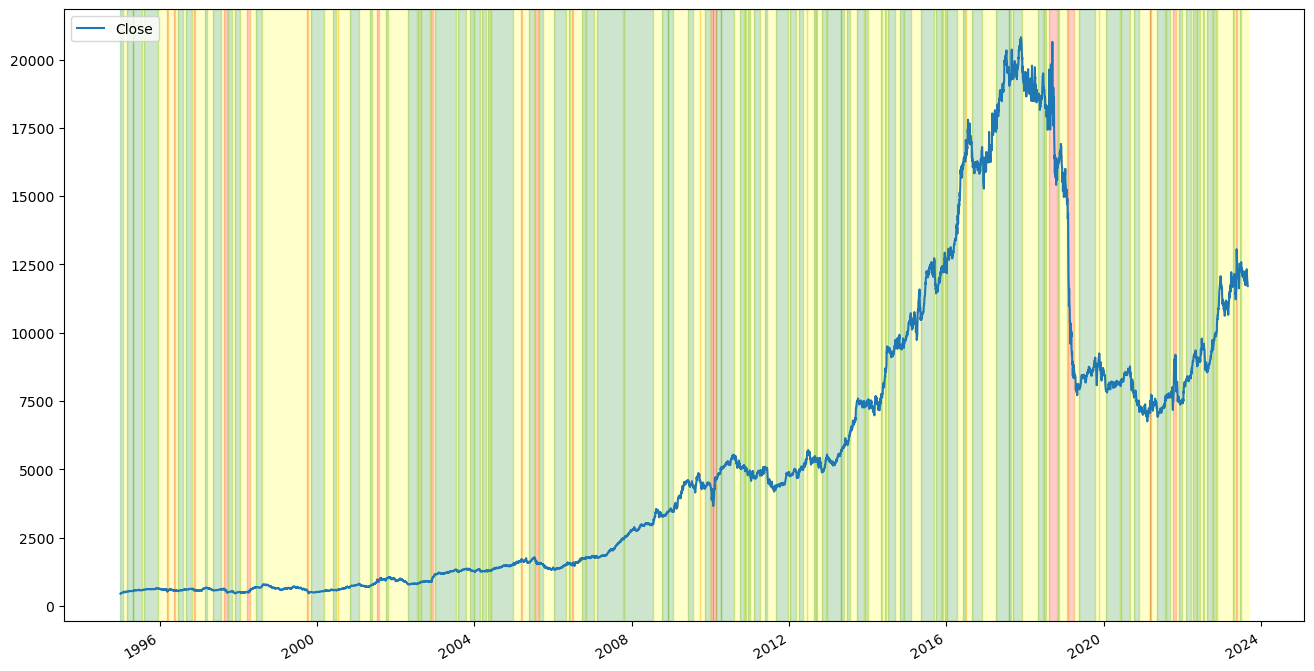

In [59]:
# simulate using the best model
spx = [spx_data.loc[spx_data.index[0], 'Close']]
state = np.random.choice(np.arange(n_regimes), p=pi)
states = [state]
for i in range(len(spx_data)-1):    
    spx.append(spx[-1] * np.exp((mu[state] - sigma[state]**2/2)/252 + sigma[state]*np.random.normal()/np.sqrt(252)))
    state = np.random.choice(np.arange(n_regimes), p=transition[state])
    states.append(state)
states = np.array(states)
sim_df = pd.DataFrame({'Close': spx}, index=spx_data.index)
sim_df.plot(figsize=(16, 9))
plot_regimes(states, spx_data.index)

# PDV model for VIX

In [7]:
pdv_initial_params = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
vix_model = PDV2Exp(pdv_initial_params)
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
vix_model.optimise(data, window, lower_bound=lower_bound, upper_bound=upper_bound)
print(vix_model.params)
vix_model.evaluate(data, window)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9078e+00                                    3.06e+01    
       1              2         1.7759e+00      1.32e-01       3.63e+00       1.18e+01    
       2              3         1.7013e+00      7.46e-02       2.94e+00       2.39e-01    
       3              4         1.7002e+00      1.04e-03       1.46e+00       4.28e-01    
       4              5         1.7001e+00      1.68e-04       2.17e+00       4.07e-02    
       5              6         1.7000e+00      1.75e-05       8.13e-01       1.12e-02    
       6              7         1.7000e+00      4.01e-06       5.28e-01       3.32e-03    
       7              8         1.7000e+00      1.22e-06       2.84e-01       9.84e-04    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.9078e+00, final cost 1.7000e+00, first-order optimality 9.84e-04.
[ 5.40639378e-02 -5.64113523e-02 

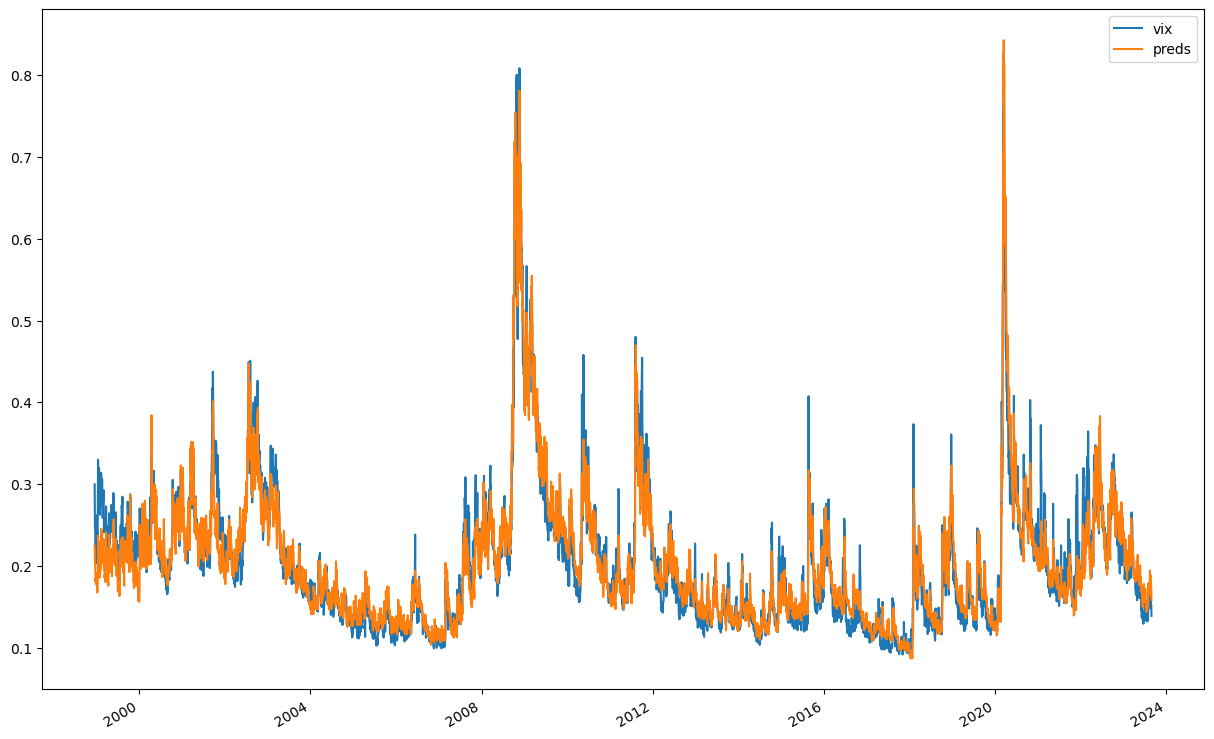

In [8]:
vix_model.plot(data, window)

# Simulate SPX + VIX

In [ ]:
sim_df = spx_model.simulate(return_df=True)

In [61]:
r_df = create_df_from_yf(sim_df, sim_df.index[0], sim_df.index[-1]+pd.Timedelta(days=1), predict_t_plus_1=predict_t_plus_1, log_return=log_return)
vix = vix_model.predict(r_df, window).numpy()
vix = list(np.zeros(window-1)) + list(vix)
sim_df['VIX'] = vix

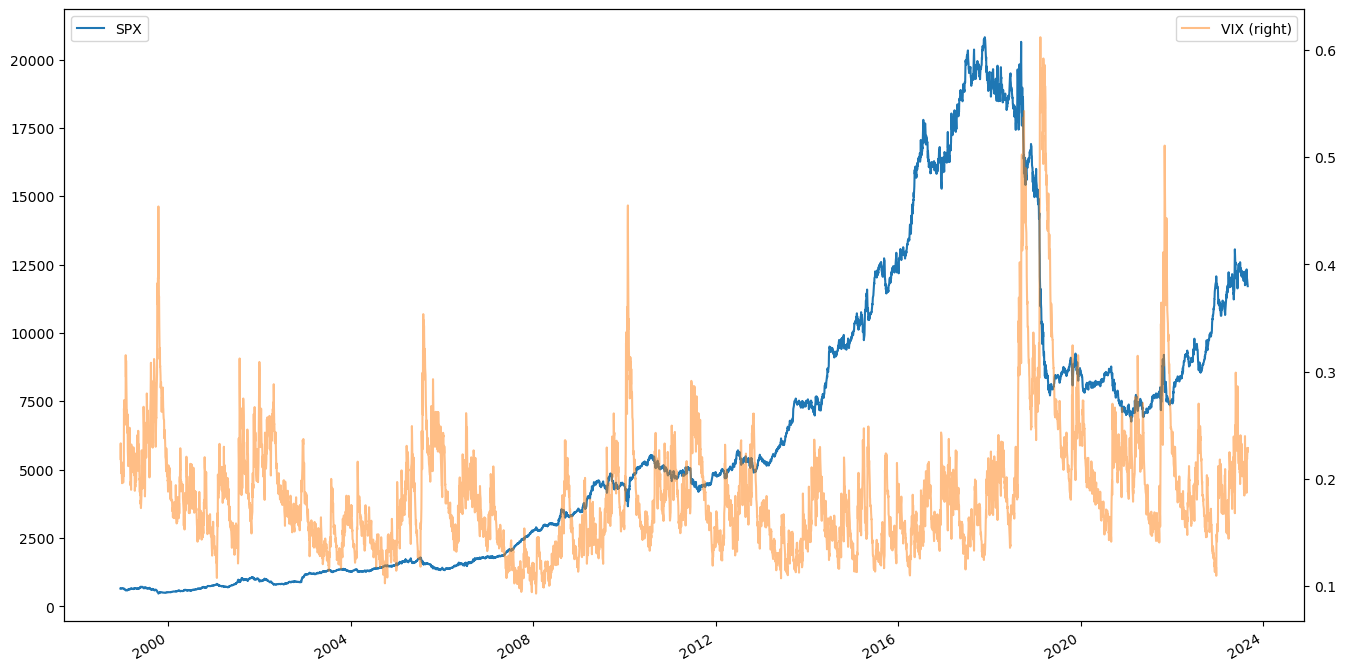

In [62]:
fig, ax = plt.subplots(figsize=(16,9))
sim_df.columns = ['SPX', 'VIX']
sim_df.loc[sim_df.index[window-1:], 'SPX'].plot(ax=ax)
sim_df.loc[sim_df.index[window-1:], 'VIX'].plot(ax=ax, secondary_y=True, alpha=0.5)
ax.legend(loc='upper left')
plt.legend()